In [1]:
import os
import cv2
import json
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from utils.data_utils import get_labels
from models.HRNet import HRNet
import numpy.ma as ma
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torchviz import make_dot
from torch.utils import data
from torchsummary import summary

# !find . -name "*.DS_Store" -type f -delete

# from utils.utils import AverageMeter
# from utils.utils import get_confusion_matrix
# from utils.utils import adjust_learning_rate

In [2]:
labels = get_labels()
trainid2label = { label.trainId : label for label in labels }

def label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for val, key in trainid2label.items():
        indices = mask == val
        mask_rgb[indices.squeeze()] = key.color 
    return mask_rgb


def display(display_list, title=True):
    plt.figure(figsize=(15, 5), dpi=150) # dpi=200
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        if title:
            plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
class Cityscapes(torch.utils.data.Dataset):

    def __init__(self, root, split = "train", mode = "fine", target_type = "instance", ignore_label=-1, 
                 multi_scale=True, is_flip=True):
        
        super(Cityscapes, self).__init__()
        
        self.root = root
        self.mode = 'gtFine' if mode == 'fine' else 'gtCoarse'
        self.images_dir = os.path.join(self.root, 'leftImg8bit', split)
        self.targets_dir = os.path.join(self.root, self.mode, split)
        self.target_type = [target_type]
        self.ignore_label = ignore_label
        self.multi_scale = multi_scale
        self.is_flip = is_flip
        self.split = split
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.crop_size = (512, 1024)
        self.base_size = 2048
        self.scale_factor = 8
        self.images = []
        self.targets = []
        
        self.TRAIN_RANDOM_BRIGHTNESS_SHIFT_VALUE = 5
        
        self.label_mapping = {-1: ignore_label, 0: ignore_label, 1: ignore_label, 
                               2: ignore_label, 3: ignore_label, 4: ignore_label, 
                               5: ignore_label, 6: ignore_label, 7: 0, 8: 1, 
                               9: ignore_label, 10: ignore_label, 11: 2, 12: 3, 
                               13: 4, 14: ignore_label, 15: ignore_label, 16: ignore_label, 
                               17: 5, 18: ignore_label, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 
                               24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 29: ignore_label, 
                               30: ignore_label, 31: 16, 32: 17, 33: 18}
        
        self.class_weights = torch.FloatTensor([0.8373, 0.918, 0.866, 1.0345, 
                                        1.0166, 0.9969, 0.9754, 1.0489,
                                        0.8786, 1.0023, 0.9539, 0.9843, 
                                        1.1116, 0.9037, 1.0865, 1.0955, 
                                        1.0865, 1.1529, 1.0507]) #.cuda()

        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            target_dir = os.path.join(self.targets_dir, city)
            for file_name in os.listdir(img_dir):
                target_types = []
                for t in self.target_type:
                    target_name = '{}_{}'.format(
                        file_name.split('_leftImg8bit')[0],
                        self._get_target_suffix(self.mode, t))
                    target_types.append(os.path.join(target_dir, target_name))

                self.images.append(os.path.join(img_dir, file_name))
                self.targets.append(target_types)
                
    def convert_label(self, seg, inverse=False):
        temp = np.copy(seg)
        if inverse:
            for v, k in self.label_mapping.items():
                seg[temp == k] = v
        else:
            for k, v in self.label_mapping.items():
                seg[temp == k] = v
        return seg
    
    def input_transform(self, img):
        img = img.astype(np.float32)[:, :, ::-1]
        img = img / 255.0
        # img -= self.mean
        # img /= self.std
        return img
    
    def label_transform(self, seg):
        return np.array(seg).astype('int32')
    
    def pad_image(self, img, h, w, size, padvalue):
        pad_image = img.copy()
        pad_h = max(size[0] - h, 0)
        pad_w = max(size[1] - w, 0)
        if pad_h > 0 or pad_w > 0:
            pad_image = cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=padvalue)
        return pad_image
    
    def rand_crop(self, img, seg):
        h, w = img.shape[:-1]
        img = self.pad_image(img, h, w, self.crop_size, (0.0, 0.0, 0.0))
        seg = self.pad_image(seg, h, w, self.crop_size, (self.ignore_label,))

        new_h, new_w = seg.shape[:-1]
        x = random.randint(0, new_w - self.crop_size[1])
        y = random.randint(0, new_h - self.crop_size[0])
        img = img[y:y+self.crop_size[0], x:x+self.crop_size[1]]
        seg = seg[y:y+self.crop_size[0], x:x+self.crop_size[1]]

        return img, seg
    
    def multi_scale_aug(self, img, seg=None, rand_scale=1):
        long_size = np.int(self.base_size * rand_scale + 0.5)
        h, w = img.shape[:2]
        if h > w:
            new_h = long_size
            new_w = np.int(w * long_size / h + 0.5)
        else:
            new_w = long_size
            new_h = np.int(h * long_size / w + 0.5)
        
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)        
        seg = cv2.resize(seg, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        seg = np.expand_dims(seg, 2)

        img, seg = self.rand_crop(img, seg)
        return img, seg
    
    def random_brightness(self, img):
        if random.random() < 0.5:
            return img
        self.shift_value = self.TRAIN_RANDOM_BRIGHTNESS_SHIFT_VALUE
        img = img.astype(np.float32)
        shift = random.randint(-self.shift_value, self.shift_value)
        img[:, :, :] += shift
        img = np.around(img)
        img = np.clip(img, 0, 255).astype(np.uint8)
        return img
            
    def __getitem__(self, index):

        img = np.array(Image.open(self.images[index]).convert('RGB'))
        seg = Image.open(self.targets[index][0])
        seg = np.expand_dims(np.array(seg), 2)
        
        if self.multi_scale:
            rand_scale = 0.5 + random.randint(0, self.scale_factor) / 10.0
            img, seg = self.multi_scale_aug(img, seg, rand_scale=rand_scale)
        else:
            h, w = self.crop_size
            img = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)        
            seg = cv2.resize(seg, (w, h), interpolation=cv2.INTER_NEAREST)
            seg = np.expand_dims(seg, 2)
            
        img = self.random_brightness(img)
        img = self.input_transform(img)

        seg = self.label_transform(seg)
        seg = self.convert_label(seg)

        img = torch.from_numpy(img.copy())
        seg = torch.from_numpy(seg.copy())
        
        img = torch.transpose(img, 2, 0)
        seg = torch.transpose(seg, 2, 0)
        
        return img, seg
    
    def __len__(self):
        return len(self.images)

    def extra_repr(self):
        lines = ["Split: {split}", "Mode: {mode}", "Type: {target_type}"]
        return '\n'.join(lines).format(**self.__dict__)

    def _load_json(self, path):
        with open(path, 'r') as file:
            data = json.load(file)
        return data

    def _get_target_suffix(self, mode, target_type):
        if target_type == 'instance':
            return '{}_instanceIds.png'.format(mode)
        elif target_type == 'semantic':
            return '{}_labelIds.png'.format(mode)
        elif target_type == 'color':
            return '{}_color.png'.format(mode)
        else:
            return '{}_polygons.json'.format(mode)

In [4]:
train_dataset = Cityscapes(
    root='data/cityscapes', 
    split='train', 
    mode='fine',
    target_type='semantic',
    multi_scale=True
)

valid_dataset = Cityscapes(
    root='data/cityscapes', 
    split='val', 
    mode='fine',
    target_type='semantic',
    multi_scale=False
)

torch.Size([3, 1024, 512]) torch.Size([1, 1024, 512])


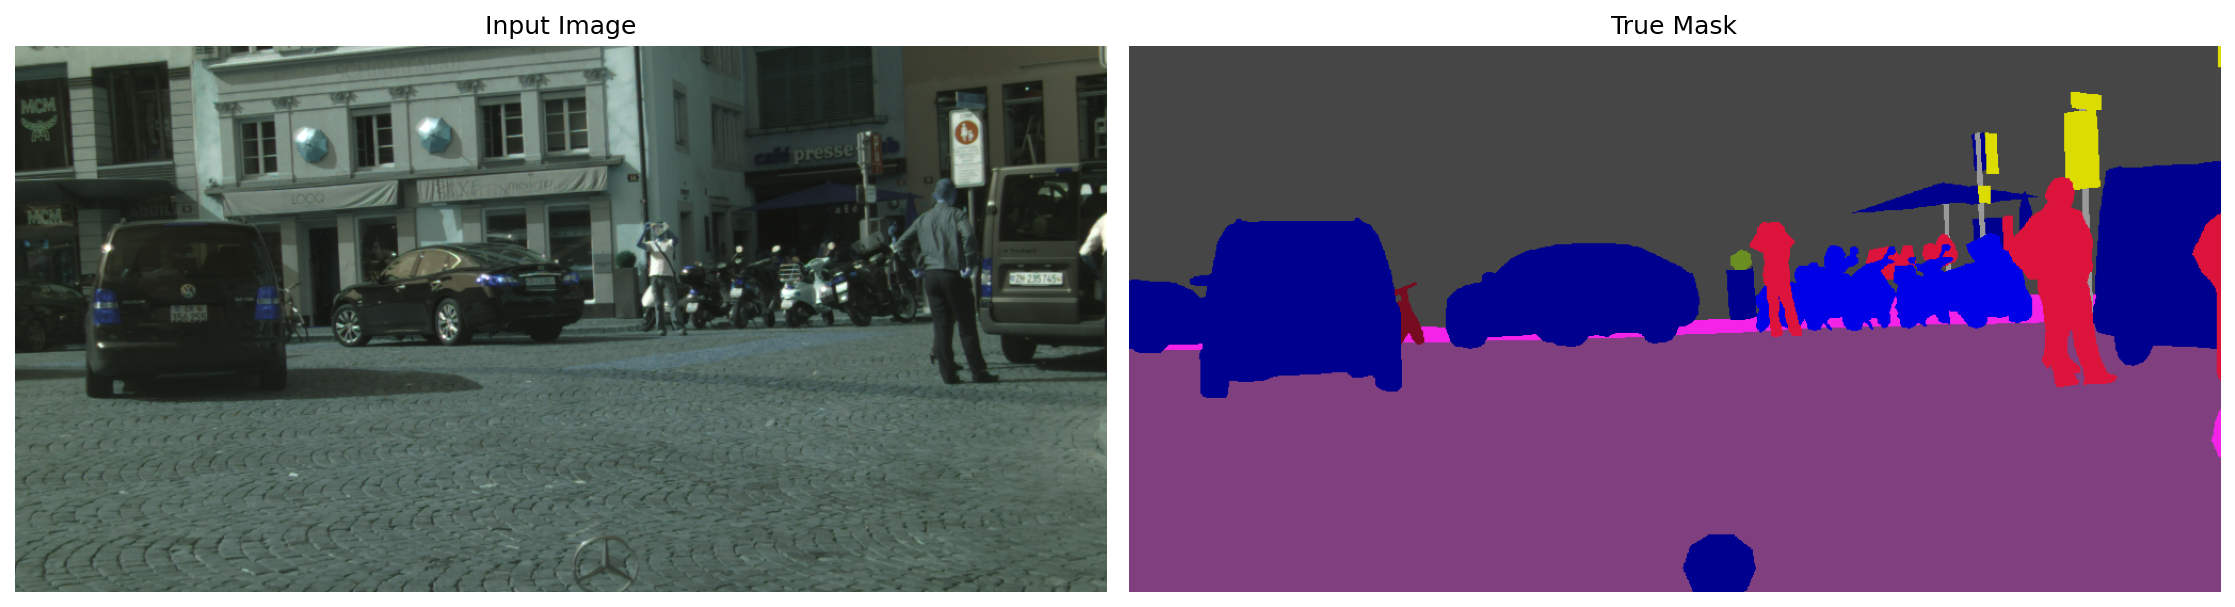

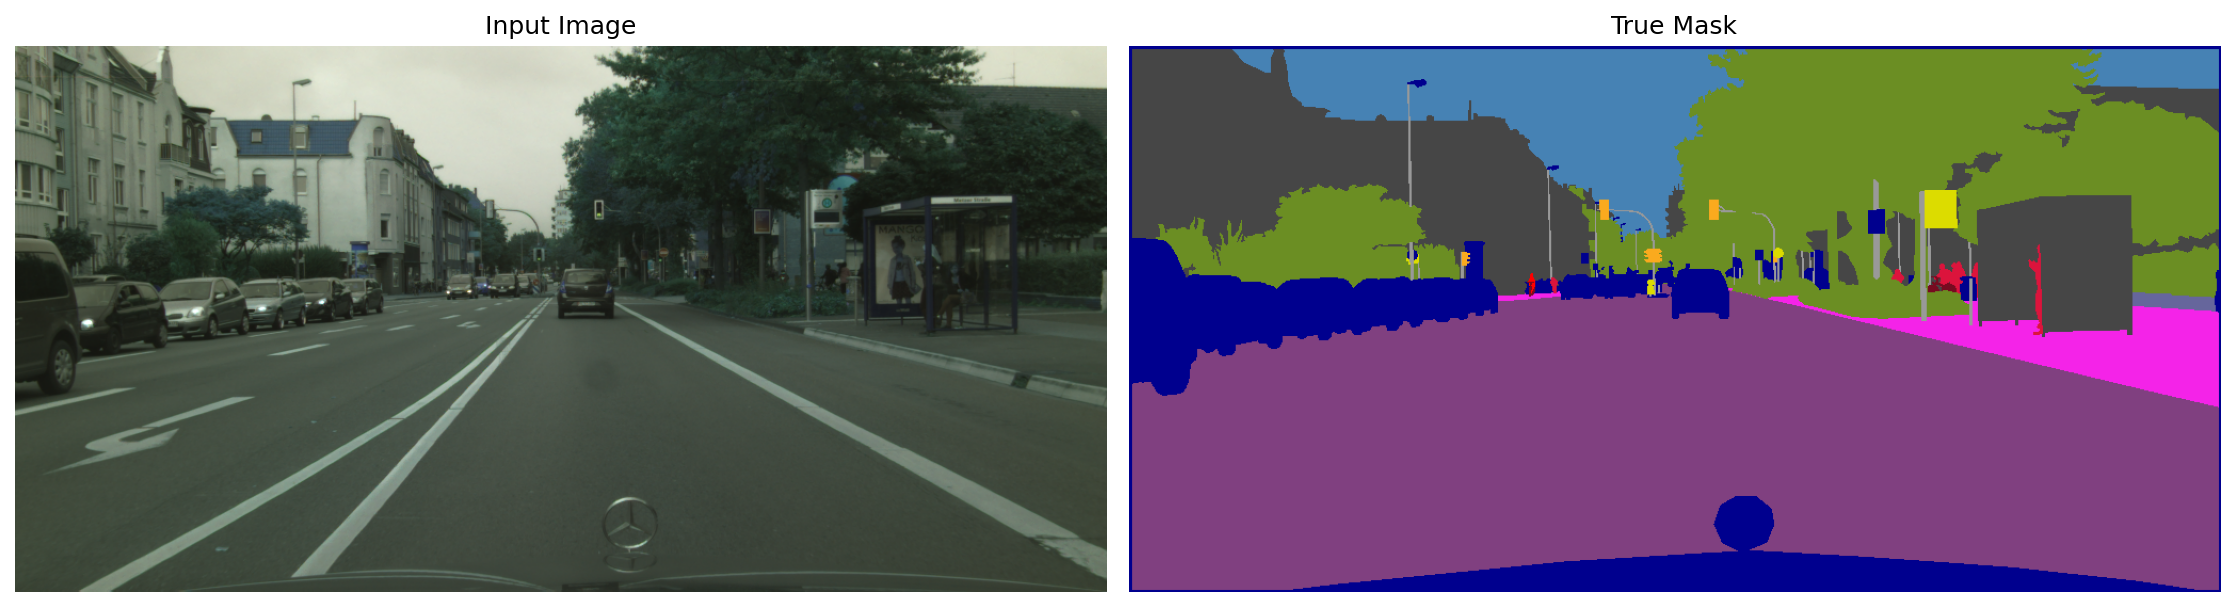

In [5]:
idx = 0

img, seg = train_dataset[idx]
print(img.shape, seg.shape)
display([torch.transpose(img, 2, 0), label_to_rgb(torch.transpose(seg, 2, 0))])
img, seg = valid_dataset[idx]
display([torch.transpose(img, 2, 0), label_to_rgb(torch.transpose(seg, 2, 0))])

In [6]:
model = HRNet(
    stage1_cfg = {'NUM_MODULES': 1,'NUM_BRANCHES': 1,'BLOCK': 'BOTTLENECK','NUM_BLOCKS': [4]}, 
    stage2_cfg = {'NUM_MODULES': 1,'NUM_BRANCHES': 2,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4]},
    stage3_cfg = {'NUM_MODULES': 4,'NUM_BRANCHES': 3,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4, 4]},
    stage4_cfg = {'NUM_MODULES': 3,'NUM_BRANCHES': 4,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4, 4, 4]},
    input_height = 512, 
    input_width = 1024, 
    n_classes = 19, 
    W = 48,
)

In [7]:
x = torch.randn(1, 3, 512, 1024)
with torch.no_grad():
    pred = model(x) 
print(pred.shape)

/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 19, 128, 256])


In [8]:
# make_dot(pred.mean(),  params=dict(model.named_parameters())).render("hrnet_torchviz", format="png")

In [9]:
train_dataloader = data.DataLoader(
    dataset=train_dataset,
    batch_size=12,
    shuffle=True
)

valid_dataloader = data.DataLoader(
    dataset=valid_dataset,
    batch_size=12,
    shuffle=True
)

In [10]:
x, y = next(iter(train_dataloader))

In [11]:
print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([12, 3, 1024, 512]); type: torch.float32
x = min: 0.0; max: 1.0
y = shape: torch.Size([12, 1, 1024, 512]); class: tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 17, 18],
       dtype=torch.int32); type: torch.int32


In [12]:
# summary = summary(model, (3, 512, 1024))

[tutorial](https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-training-3-4-8242d31de234)

In [ ]:
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None \
                and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    # learning rate scheduler step with validation loss
                    self.lr_scheduler.batch(self.validation_loss[i])  
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 
                          'Training', total=len(self.training_DataLoader), leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader),
                          'Validation', total=len(self.validation_DataLoader), leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()